In [182]:
import numpy as np
import pandas as pd
import torch
import copy
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from zifa_github import *
from scipy.stats import spearmanr
from sklearn.decomposition import FactorAnalysis
import seaborn as sns
from sklearn.manifold import TSNE
import random



In [194]:
def dist_z(Z):
    dist=np.zeros((Z.shape[0],Z.shape[0]))
    for i in range(Z.shape[0]):
        for j in range(Z.shape[0]):
            dist[i,j]=(Z[j,:]-Z[i,:]).dot(Z[j,:]-Z[i,:])
    return dist
    pass
def get_corr(Z,Zhat):
    D=dist_z(Z)
    Dhat=dist_z(Zhat)
    rho, pval = spearmanr(D,Dhat,axis=None)
    return rho

def gen_data(sample_size=200,l=10,D=200,lam=0.05):
    np.random.seed(random.randint(1,5000))
    z= np.random.multivariate_normal(np.zeros(l), np.eye(l), sample_size)
    A=np.random.rand(D,l)-0.5
    mu=np.random.randn(D)+6
    # print(mu.size)
    W=np.diag(np.random.rand(D))
    x=[]
    for i in range(sample_size):
        x.append( np.random.multivariate_normal(A.dot(z[i])+mu, W, 1)[0])
    x=np.array(x)
    p=np.exp(-lam*x*x )
    h=np.random.binomial(1,p)
    # print(h)
    y=x*(1-h)
    # print(z.shape)
    # print(x.shape)
    return z, np.abs(y), W, mu, lam

# z,y,W, mu, lam=gen_data()

def simulate(n=20):
    results_dict={}
    results_dict["Corr of Distance"]=[]
    results_dict["err of Lambda"]=[]
    results_dict["Corr of Mu"]=[]
    results_dict["Corr of W"]=[]
    for i in range(n):
        z1,y,W, mu, lam=gen_data()
        print(W)
        EZ,params=fitModel(y,K=10)
        print(get_corr(z1,EZ))
        results_dict["Corr of Distance"].append(get_corr(z1,EZ))
        results_dict["err of Lambda"].append((lam-params['decay_coef'])*(lam-params['decay_coef']) )
        results_dict["Corr of Mu"].append( spearmanr(params['mus'],mu )[0])
        results_dict["Corr of W"].append( spearmanr(params['sigmas'],np.diag(W))[0] )
        del z1,y,W, mu, lam,EZ,params
    return results_dict
    pass


In [195]:
err_dict=simulate(20)
err_df=DataFrame(err_dict)



[[0.19466134 0.         0.         ... 0.         0.         0.        ]
 [0.         0.95522395 0.         ... 0.         0.         0.        ]
 [0.         0.         0.489845   ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.76289921 0.         0.        ]
 [0.         0.         0.         ... 0.         0.18450432 0.        ]
 [0.         0.         0.         ... 0.         0.         0.35860678]]
Running zero-inflated factor analysis with N = 200, D = 200, K = 10
Param change below threshold 1.000e-02 after 9 iterations
0.9502015433208193
[[0.50987211 0.         0.         ... 0.         0.         0.        ]
 [0.         0.09771677 0.         ... 0.         0.         0.        ]
 [0.         0.         0.30313783 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2799193  0.         0.        ]
 [0.         0.         0.         ... 0.         0.1762395  0.        ]
 [0.         0.         0.         ... 0.

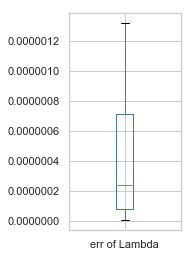

In [201]:
err_df.boxplot(column=["err of Lambda"],figsize=(2,4))


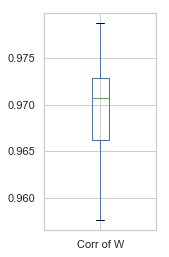

In [200]:
err_df.boxplot(column=["Corr of W"],figsize=(2,4))

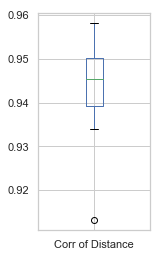

In [199]:
err_df.boxplot(column=["Corr of Distance"],figsize=(2,4))

In [159]:
import matplotlib.pyplot as plt
plt.scatter(err_df['Corr of W'][0][0],err_df['err of W'][0][1])
plt.show()

IndexError: invalid index to scalar variable.

In [ ]:
err_df.boxplot(column=["Corr of Distance"],figsize=(2,4))

In [ ]:
err_df.boxplot(column=["err of Lambda"],figsize=(2,4))

In [ ]:
def dist_z(Z):
    dist=np.zeros((Z.shape[0],Z.shape[0]))
    for i in range(Z.shape[0]):
        for j in range(Z.shape[0]):
            dist[i,j]=(Z[j,:]-Z[i,:]).dot(Z[j,:]-Z[i,:])
    return dist
    pass
def get_corr(Z,Zhat):
    D=dist_z(Z)
    Dhat=dist_z(Zhat)
    rho, pval = spearmanr(D,Dhat,axis=None)
    return rho
get_corr(z,EZ)

In [ ]:
true_label=pd.read_csv("CORTEX data\labels.txt",sep=" ",header=None).values[:,0]
data=pd.read_csv("CORTEX data\gene_expression.txt",sep=" ",header=None)
data=data.values

In [ ]:
for K in range(4,20,4):
    EZ,params=fitModel(data,K=K)
    torch.save((EZ,params),"ZIFA_param_K{}.pkl".format(K))

In [ ]:
def get_average_ari(Z,true_label,n=20):
    aris=[]
    for i in range(n):
        clustering_label = KMeans(n_clusters=7, random_state=i).fit_predict(Z)
        aris.append(adjusted_rand_score(clustering_label,true_label))
    return aris

In [ ]:
results_dict={}
for K in range(2,20,2):
    EZ,params=torch.load("ZIFA_param_K{}.pkl".format(K))
    results_dict[str(K)]=get_average_ari(EZ,true_label)
results_dict.keys()
df=DataFrame(results_dict)
boxplot = df.boxplot(column=['2','4','6','8','10','12','14','16','18'],figsize=(9,12))




In [ ]:

VAE_EZ=torch.load("VAE\VAE.pkl")
results_dict["Gaussian VAE"]=get_average_ari(VAE_EZ,true_label)
VAE_poi=torch.load("VAE\VAE_poi.pkl")
results_dict["Poisson VAE"]=get_average_ari(VAE_poi,true_label)
VAE_2_EZ=torch.load("VAE\VAE_2.pkl")
results_dict["ZI_VAE"]=get_average_ari(VAE_2_EZ,true_label)



In [ ]:
results_dict["ZIFA"]=results_dict["12"]
df=DataFrame(results_dict)
boxplot = df.boxplot(column=["ZIFA",'Gaussian VAE','Poisson VAE','ZI_VAE'],figsize=(9,12))

In [ ]:
VAE_2_EZ=torch.load("VAE\VAE_2.pkl")
results_dict["ZI_VAE"]=get_average_ari(VAE_2_EZ,true_label)
for i in range(10):
    clustering_label = KMeans(n_clusters=7, random_state=i).fit_predict(VAE_2_EZ)
    print(adjusted_rand_score(clustering_label,true_label))

In [ ]:
def tsne_vis(Z,label):
    palette = sns.color_palette("bright", 7)
    X_embedded = TSNE(n_components=2).fit_transform(Z)
    sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=label, legend='brief', alpha=0.5,palette=palette)